In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from copy import deepcopy
from bhad.utils import Discretize
from bhad.model import BHAD

https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits

In [2]:
# Read data
mat = scipy.io.loadmat('/home/alexv84/Documents/Arbeit/Allianz/AZVers/data/pendigits.mat')   
#mat = scipy.io.loadmat('/home/alexv84/Documents/Arbeit/Allianz/AZVers/data/wbc.mat')  # Wisconsin Breast Cancer dataset

X = deepcopy(mat['X'])
X = pd.DataFrame(X,columns=["Feature "+str(i) for i in np.arange(X.shape[1])])
print(X.shape)

y = deepcopy(mat['y'].squeeze().astype(float))
print(np.unique(y, return_counts=True))

# y[y == 1] = -1.
# y[y == 0] = 1.

(6870, 16)
(array([0., 1.]), array([6714,  156]))


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify=y)


In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

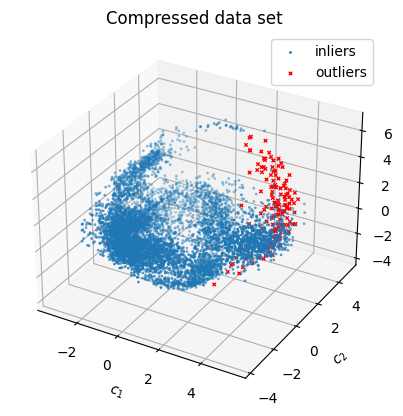

In [5]:
# Plot all the ground truth points together with the predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
#ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=0, label = "inliers")
ax.scatter(X_reduce[y == 0, 0], X_reduce[y == 0, 1], zs=X_reduce[y == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y == 1, 0], X_reduce[y == 1, 1], zs=X_reduce[y == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
plt.show();

In [6]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete' , Discretize(nbins = None, verbose = False)),      # step only needed if continous features are present
    ('model', BHAD(contamination = 0.01))
])

y_pred_train = pipe.fit_predict(X_train)
scores_train = pipe.decision_function(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Fit BHAD on discretized data.
Input shape: (4602, 16)
One-hot encoding categorical features.
Matrix dimension after one-hot encoding: (4602, 529)
Finished training.
Score input data.
Score input data.


In [7]:
y_pred_test = pipe.predict(X_test)
scores_test = pipe.decision_function(X_test)


Score input data.
Apply fitted one-hot encoder.

Score input data.
Apply fitted one-hot encoder.


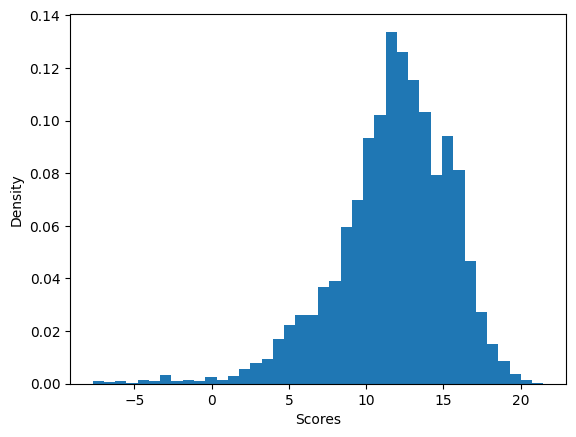

In [8]:
plt.hist(scores_train, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

In [9]:
from sklearn.metrics import classification_report

y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_train, y_pred_train, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       0.98      0.99      0.99      4498
     Outlier       0.47      0.21      0.29       104

    accuracy                           0.98      4602
   macro avg       0.73      0.60      0.64      4602
weighted avg       0.97      0.98      0.97      4602



In [10]:
print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       0.98      1.00      0.99      2216
     Outlier       0.65      0.25      0.36        52

    accuracy                           0.98      2268
   macro avg       0.82      0.62      0.68      2268
weighted avg       0.98      0.98      0.98      2268



In [11]:
num_cols = list(X_train.select_dtypes(include=['float', 'int']).columns) 
cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [12]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete', Discretize(nbins = None, verbose = True)),     
    ('model', BHAD(contamination = 0.01, num_features = num_cols, cat_features = cat_cols))
])

y_pred_train = pipe.fit_predict(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Input shape: (4602, 16)
Used 16 numeric feature(s) and 0 categorical feature(s).
Determining optimal number of bins for numeric features
Feature Feature 0 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 1 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 2 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 3 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 4 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 5 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 6 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 7 using 49 bins
Determining optimal number of bins for numeric features
Feature Feature 8 using 49 bins
Determining optimal number of bins for numeric features
Feature Featur

In [17]:
from bhad import explainer

local_expl = explainer.Explainer(pipe.named_steps['model'], pipe.named_steps['discrete']).fit()

--- BHAD Model Explainer ---

Using fitted BHAD and discretizer.
Marginal distributions estimated using train set of shape (4602, 16)


In [18]:
df_train = local_expl.get_explanation(append = True)

df_train.head(5)

Create local explanations for 4602 observations.


  0%|          | 0/4602 [00:00<?, ?it/s]

,Feature 0,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,explanation
0,0.000000,1.000000,0.621676,0.987233,1.000000,0.918908,0.665447,0.604405,0.431481,0.257223,0.217593,0.000000,0.112855,0.337457,0.731729,0.368009,Feature 12 (Cumul.perc.: 0.039): 0.11\nFeature...
1,0.939155,1.000000,0.637973,0.813388,0.361896,0.486711,0.277245,0.122129,0.749405,0.000000,1.000000,0.268164,0.504903,0.402460,0.000000,0.271293,Feature 7 (Cumul.perc.: 0.134): 0.12\nFeature ...
2,0.510702,0.626126,0.591352,1.000000,0.787834,0.702042,0.563545,0.311009,0.195960,0.000000,0.000000,0.058847,0.471414,0.241549,1.000000,0.191576,Feature 15 (Cumul.perc.: 0.641): 0.19\nFeature...
3,0.333355,1.000000,0.151542,0.505874,0.596795,0.405057,0.331479,0.000000,0.000000,0.142961,0.102682,0.702734,0.488228,0.952240,1.000000,0.942688,Feature 3 (Cumul.perc.: 0.042): 0.51\nFeature ...
4,0.463657,0.957844,0.356373,0.624027,0.435407,0.178423,0.046462,0.000000,0.000000,0.291058,0.174890,0.708834,0.565004,0.912065,1.000000,1.000000,Feature 5 (Cumul.perc.: 0.036): 0.18\nFeature ...


In [19]:
for obs, ex in enumerate(df_train.explanation.values):
    if (obs % 20) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 Feature 12 (Cumul.perc.: 0.039): 0.11
Feature 14 (Cumul.perc.: 0.609): 0.73
Feature 15 (Cumul.perc.: 0.739): 0.37
Feature 10 (Cumul.perc.: 0.255): 0.22
Feature 9 (Cumul.perc.: 0.421): 0.26

Obs. 20:
 Feature 12 (Cumul.perc.: 0.07): 0.21
Feature 10 (Cumul.perc.: 0.393): 0.54
Feature 7 (Cumul.perc.: 0.799): 0.76
Feature 4 (Cumul.perc.: 0.18): 0.11
Feature 9 (Cumul.perc.: 0.876): 0.73

Obs. 40:
 Feature 2 (Cumul.perc.: 0.945): 0.89
Feature 0 (Cumul.perc.: 0.726): 0.59
Feature 9 (Cumul.perc.: 0.324): 0.15
Feature 8 (Cumul.perc.: 0.384): 0.44
Feature 1 (Cumul.perc.: 0.192): 0.71

Obs. 60:
 Feature 2 (Cumul.perc.: 0.963): 0.97
Feature 7 (Cumul.perc.: 0.87): 0.88
Feature 9 (Cumul.perc.: 0.763): 0.57
Feature 6 (Cumul.perc.: 0.282): 0.31
Feature 8 (Cumul.perc.: 0.359): 0.41

Obs. 80:
 Feature 5 (Cumul.perc.: 0.015): 0.01
Feature 3 (Cumul.perc.: 0.014): 0.36
Feature 11 (Cumul.perc.: 0.949): 0.76
Feature 13 (Cumul.perc.: 0.889): 0.9
Feature 4 (Cumul.perc.: 0.365): 0.43

Obs. 100:
 Featu

In [20]:
global_feat_imp = local_expl.global_feat_imp         # based on X_train

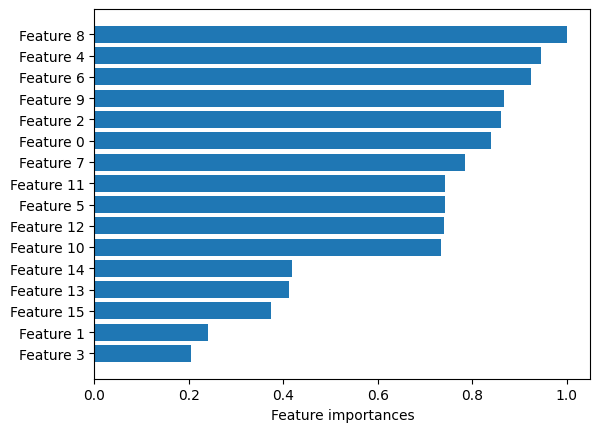

In [21]:
from matplotlib import pyplot as plt

plt.barh(global_feat_imp.index, global_feat_imp.values.flatten())
plt.xlabel("Feature importances");

#plt.savefig('global_importances.png')   # save the figure to file
plt.show();
plt.close();    # close the figure window